In [2]:
%gui qt
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
import numpy as n
from matplotlib import pyplot as plt
import napari

# path to wherever the s2p-lbm repository is cloned on your computer
os.chdir(os.path.dirname(os.path.abspath("")))

# set to "false" to run code without messages intended for developers
os.environ["SUITE3D_DEVELOPER"] = "true"

import suite3d
from suite3d.job import Job
from suite3d import ui
from suite3d import io
from suite3d import plot_utils

import mbo_utilities as mbo
import lbm_suite2p_python as lsp
from icecream import ic

import fastplotlib as fpl

## for this nb only
from suite3d.utils import to_int, default_log, get_matching_params, make_batch_paths


Install gitpython for dev benchmarking to work


fastplotlib version from git (0.4.0) and __version__ (0.5.0) don't match.


In [4]:
corr_map_param_names = [
    "voxel_size_um",
    "temporal_hpf",
    "edge_crop_npix",
    "npil_filt_type",
    "npil_filt_z_um",
    "npil_filt_xy_um",
    "cell_filt_type",
    "cell_filt_z_um",
    "cell_filt_xy_um",
    "fix_vmap_edge_planes",
    "detection_timebin",
    "sdnorm_exp",
    "intensity_thresh",
    "standard_vmap",
]

computation_param_names = ["n_proc", "dtype", "t_batch_size"]

In [5]:
fpath = Path(r"D:\W2_DATA\kbarber\2025_03_01\mk301")
job_path = fpath.joinpath("results")
tif_path = fpath.joinpath("green")

In [6]:
job_id_list = ["03_27", "v5_dt25", "v5_mbo"]
idx = 1

job = Job(job_path, job_id_list[idx], create=False, overwrite=False, verbosity = 1)

print(job_id_list[idx])

   Found and loaded params from D:\W2_DATA\kbarber\2025_03_01\mk301\results\s3d-v5_dt25\params.npy
v5_dt25


In [7]:
# ~1.5*fs
res = job.load_corr_map_results()

In [8]:
_=ic(job.params["npil_filt_xy_um"], job.params["cell_filt_xy_um"], job.params["cell_filt_z_um"], job.params["npil_filt_type"], job.params["cell_filt_type"], job.params["detection_timebin"], job.params["intensity_thresh"])

ic| job.params["npil_filt_xy_um"]: 3.0
    job.params["cell_filt_xy_um"]: 5.0
    job.params["cell_filt_z_um"]: 18
    job.params["npil_filt_type"]: 'gaussian'
    job.params["cell_filt_type"]: 'gaussian'
    job.params["detection_timebin"]: 25
    job.params["intensity_thresh"]: 0.7


Data provided and set.
Is running jupyter


RFBOutputContext()

JupyterRenderCanvas(css_height='500.0px', css_width='500.0px')
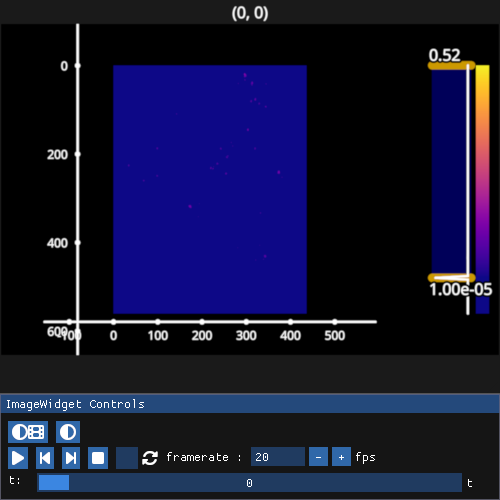

In [26]:
iw = mbo.run_gui(res["vmap"], figure_kwargs={"size": (500, 500)})
iw.show()

In [27]:
iw.close()

In [9]:
mov = job.get_registered_movie("registered_fused_data", "fused")
mov

dask.array<astype, shape=(14, 5632, 561, 437), dtype=float32, chunksize=(14, 100, 561, 437), chunktype=numpy.ndarray>

In [10]:
nz, nt, ny, nx = mov.shape
_=ic(nz, nt, ny, nx)

ic| nz: 14, nt: 5632, ny: 561, nx: 437


In [11]:
t_batch_size = job.params["t_batch_size"]
dtype = job.params["dtype"]
_=ic(t_batch_size, dtype)

ic| t_batch_size: 300, dtype: <class 'numpy.float32'>


In [12]:
n_batches = to_int(n.ceil(nt / t_batch_size))
ic(n_batches)

ic| n_batches: 19


19

In [20]:
corr_map_params = job.params
computation_params = job.params
summary = job.load_summary()
vz, vy, vx = corr_map_params["voxel_size_um"]
nb, nz, ny, nx = mov.shape

npil_filt_type = corr_map_params["npil_filt_type"]
edge_crop_npix = corr_map_params["edge_crop_npix"]
if edge_crop_npix is not None and edge_crop_npix > 0:
    assert summary is not None
npil_filt_pix = (
    (corr_map_params["npil_filt_z_um"] / vz),
    (corr_map_params["npil_filt_xy_um"] / vy),
    (corr_map_params["npil_filt_xy_um"] / vx),
)
cell_filt_type = corr_map_params["cell_filt_type"]
cell_filt_pix = (
    (corr_map_params["cell_filt_z_um"] / vz),
    (corr_map_params["cell_filt_xy_um"] / vy),
    (corr_map_params["cell_filt_xy_um"] / vx),
)
sdnorm_exp = corr_map_params["sdnorm_exp"]
intensity_thresh = corr_map_params["intensity_thresh"]
# fix_vmap_edge_planes = corr_map_params["fix_vmap_edge_planes"]

# these parameters relate to computational resources
n_processors = computation_params["n_proc"]
dtype = computation_params["dtype"]
minibatch_size = max(20, int(n.ceil(nb / n_processors)))

In [21]:
temporal_hpf = to_int(corr_map_params["temporal_hpf"])
temporal_hpf = min(nb, temporal_hpf)
temporal_hpf

14

In [15]:
accum = suite3d.corrmap.init_corr_map_accumulators((nz, ny, nx), dtype)

In [16]:
from suite3d import extension as ext
from suite3d.utils import default_log as log
import dask.array as darr

for i, batch_idx in enumerate(range(n_batches)):
    if i == 0:
        _=ic(batch_idx)
        job.log("prep", tic=True)
        start_idx = batch_idx * t_batch_size
        end_idx = min(nt, start_idx + t_batch_size)
        job.log("Running batch %d of %d" % (batch_idx + 1, n_batches), 2)
        mov_batch = mov[:, start_idx:end_idx]
        if corr_map_params.get("detection_timebin", 1) > 1:
            mov_batch_bin = ext.binned_mean_ax1(mov_batch, corr_map_params["detection_timebin"] )
        mov_batch_swap = darr.swapaxes(mov_batch, 0, 1).compute().astype(dtype)

ic| batch_idx: 0


In [21]:
mov_batch.shape

(14, 300, 561, 437)

In [18]:
fpl.ImageWidget(mov_batch_bin).show()

In [19]:
vmap_2, mov_sub = dtu.filter_and_reduce_movie(
    mov,
    npil_filt_type,
    npil_filt_pix,
    cell_filt_type,
    cell_filt_pix,
    intensity_thresh,
    n_processors,
    minibatch_size,
    standard_vmap=corr_map_params["standard_vmap"],
    log=log,
    pool=pool,
)

[autoreload of mbo_utilities.graphics.run_gui failed: Traceback (most recent call last):
  File "C:\Users\RBO\miniforge3\envs\s3d\Lib\site-packages\IPython\extensions\autoreload.py", line 283, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\RBO\miniforge3\envs\s3d\Lib\site-packages\IPython\extensions\autoreload.py", line 483, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "C:\Users\RBO\miniforge3\envs\s3d\Lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "C:\Users\RBO\repos\mbo_utilities\mbo_utilities\graphics\run_gui.py", line 5, in <module>
    from ..file_io import ScanMultiROIReordered, to_lazy_array, load_data_path
ImportError: cannot import name 'load_data_path' from 'mbo_utiliti

NameError: name 'dtu' is not defined